In [1]:
base_dir = '/home/shaeo/cadd_training/20250915_AQME'

In [ ]:
import os
import pandas as pd

# データの取得
df = pd.read_csv('https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/Lipophilicity.csv')
df.rename(columns={'smiles':'SMILES', 'CMPD_CHEMBLID':'code_name'}, inplace=True)
os.makedirs(base_dir + '/dataset', exist_ok=True)
df.to_csv(base_dir + '/dataset/lipophilicity.csv', index=False)

## CSERCH&QDESCP

In [ ]:
import glob
from aqme.csearch import csearch
from aqme.qdescp import qdescp

In [ ]:
csearch(
    input='dataset/lipophilicity.csv',
    program='rdkit',
    w_dir_main=base_dir,
    sample=25,  # コンフォメーションの生成数
    ff='MMFF',  # 最適化に利用する力場
    ewin_csearch=5, # エネルギーの閾値
    nprocs=12   # プロセス数（要検討）
)

In [ ]:
sdf_rdkit_files = glob.glob(f'CSEARCH/*.sdf')
qdescp(
    program='xtb',
    files=sdf_rdkit_files,
    robert=False,   # ROBERT用のデータベース作成
    nprocs=12,  # プロセス数（要検討）
    boltz=True, # ボルツマン重み付け平均+RDkit記述子の算出
    qdescp_temp=300,    # QM計算に使用する温度
)

In [ ]:
import re
from pathlib import Path
from collections import defaultdict
from aqme.qdescp_utils import *

In [ ]:
# AQMEの関数をラップする

def safe_average_properties(boltz, prop_list):
    try:
        if all(isinstance(p, (int, float)) for p in prop_list):
            # 全部 float
            return average_prop_mol(boltz, prop_list)
        elif all(isinstance(p, (list, np.ndarray)) for p in prop_list):
            # 全部 list/ndarray
            return average_prop_atom(boltz, prop_list)
        else:
            # 混在 or None/NaN
            return np.nan
    except Exception:
        return np.nan

def safe_full_level_boltz(descp_dict, json_files, energy, smarts_targets, full_json_data):
    boltz = get_boltz(energy)
    atomic_props = False

    # 原子プロパティ
    for i, prop in enumerate(descp_dict['atom_props']):
        if i == 0:
            for json_file in json_files:
                j = read_json(json_file)
                for atom_prop in descp_dict['atom_props']:
                    if j and atom_prop in j:
                        atomic_props = True
                        break
        if atomic_props:
            try:
                prop_list = [read_json(jf)[prop] for jf in json_files]
                avg_prop = safe_average_properties(boltz, prop_list, is_atom_prop=True)
            except Exception:
                avg_prop = np.nan
        else:
            avg_prop = np.nan
        update_full_json_data(full_json_data, prop, avg_prop, smarts_targets)

    # 分子プロパティ
    for prop in descp_dict['mol_props']:
        try:
            prop_list = [read_json(jf)[prop] for jf in json_files]
            avg_prop = safe_average_properties(boltz, prop_list, is_atom_prop=False)
        except Exception:
            avg_prop = np.nan
        full_json_data[prop] = avg_prop

    return full_json_data, atomic_props

In [ ]:
def group_json_by_molecule(json_paths):
    """ *_conf_*.json を化合物ごとにグルーピング """
    groups = defaultdict(list)
    for p in json_paths:
        key = re.split(r"_conf_\d+", p)[0]
        groups[key].append(p)
    return groups

def ensure_dir(p: Path):
    p.mkdir(parents=True, exist_ok=True)
    return p

def slice_level_json(full_json_data, descp_dict):
    """full_json_data から denovo / interpret 用のサブセットを作る"""
    denovo = {}
    interpret = {}
    for k in descp_dict['denovo_mols'] + descp_dict['denovo_atoms']:
        denovo[k] = full_json_data.get(k, np.nan)
    for k in descp_dict['interpret_mols'] + descp_dict['interpret_atoms']:
        interpret[k] = full_json_data.get(k, np.nan)
    return denovo, interpret

def json_to_df_rows(pattern, add_code_name=True):
    rows = []
    for jf in glob.glob(pattern):
        data = pd.read_json(jf, typ='series')  # dict型として読み込む
        s = data.copy()
        if add_code_name:
            base = os.path.basename(jf)
            code_name = "_".join(base.split("_")[:-2])
            s = pd.concat([pd.Series({"code_name": code_name}), s])
        rows.append(s)
    return pd.DataFrame(rows) if rows else pd.DataFrame()

In [ ]:
json_root = Path(base_dir + "/QDESCP")   # JSON のあるフォルダ
out_root = Path(base_dir + "/QDESCP")    # 出力先
boltz_dir = ensure_dir(out_root / "boltz")
raw_dir = ensure_dir(out_root / "raw_csv_databases")

# 1) JSON を収集
json_paths = list(Path(json_root).rglob("*_conf_*.json"))
if not json_paths:
    raise FileNotFoundError(f"No *_conf_*.json found under {json_root}")

# 2) グループ化
groups = group_json_by_molecule([str(p) for p in json_paths])
descp_dict = collect_descp_lists()

# 3) 各化合物ごとに Boltzmann 平均
for mol_prefix, files in groups.items():
    files = sorted(files)
    name = os.path.basename(mol_prefix)
    energies = []
    for jf in files:
        j = read_json(jf)
        try:
            e = j.get("Total energy", j["optimization"]["scf"]["scf energies"][-1])
        except Exception:
            e = 0.0
        energies.append(e)
    full_json_data, _ = safe_full_level_boltz(
        descp_dict=descp_dict,
        json_files=files,
        energy=energies,
        smarts_targets=[],
        full_json_data={}
    )
    convert_ndarrays(full_json_data)
    denovo_json, interpret_json = slice_level_json(full_json_data, descp_dict)
    convert_ndarrays(denovo_json)
    convert_ndarrays(interpret_json)

    dict_to_json(str(boltz_dir / f"{name}_full_boltz.json"), full_json_data)
    dict_to_json(str(boltz_dir / f"{name}_denovo_boltz.json"), denovo_json)
    dict_to_json(str(boltz_dir / f"{name}_interpret_boltz.json"), interpret_json)

# 4) JSON → CSV
# full
full_df_raw = json_to_df_rows(str(boltz_dir / "*_full_boltz.json"))
if not full_df_raw.empty:
    full_df_raw.to_csv(raw_dir / "Raw_QDESCP_full_descriptors.csv", index=False)
    pruned = remove_atom_descp(full_df_raw.copy(), descp_dict['atom_props'])
    pruned.to_csv(out_root / "QDESCP_full_descriptors.csv", index=False)

# denovo
denovo_df_raw = json_to_df_rows(str(boltz_dir / "*_denovo_boltz.json"))
if not denovo_df_raw.empty:
    denovo_df_raw.to_csv(raw_dir / "Raw_QDESCP_denovo_descriptors.csv", index=False)
    pruned = remove_atom_descp(denovo_df_raw.copy(), descp_dict['atom_props'])
    pruned.to_csv(out_root / "QDESCP_denovo_descriptors.csv", index=False)

# interpret
interp_df_raw = json_to_df_rows(str(boltz_dir / "*_interpret_boltz.json"))
if not interp_df_raw.empty:
    interp_df_raw.to_csv(raw_dir / "Raw_QDESCP_interpret_descriptors.csv", index=False)
    pruned = remove_atom_descp(interp_df_raw.copy(), descp_dict['atom_props'])
    pruned.to_csv(out_root / "QDESCP_interpret_descriptors.csv", index=False)

In [4]:
# jsonファイルを1つのフォルダにまとめる

import shutil

qdescp_dir = base_dir + '/QDESCP'
json_dir = qdescp_dir + '/desc_json'
os.makedirs(json_dir, exist_ok=True)
for file_name in os.listdir(qdescp_dir):
    if file_name.endswith(".json"):
        src = os.path.join(qdescp_dir, file_name)
        dst = os.path.join(json_dir, file_name)
        shutil.move(src, dst)

## 予測モデル構築

In [59]:
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
import seaborn as sns
import pandas as pd
from sklearn.metrics import root_mean_squared_error, r2_score

In [33]:
# AQMEの特徴量をデータセットと紐付ける
df_base = pd.read_csv(base_dir + '/dataset/lipophilicity.csv')
df_desc = pd.read_csv(qdescp_dir + '/QDESCP_full_descriptors.csv')
df_desc['code_name'] = df_desc['code_name'].map(lambda x: x.split('_')[0]) # _rdkitの消去
df_aqme = pd.merge(df_base, df_desc, on='code_name', how='left')
df_aqme.to_csv(base_dir + '/dataset/lipophilicity_aqme.csv', header=True, index=False)

In [42]:
# RDkit descriptorをデータセットと紐付ける
desc_json = {}
for name, smi in zip(df_base['code_name'], df_base['SMILES']):
    mol = Chem.MolFromSmiles(smi)
    descrs = Descriptors.CalcMolDescriptors(mol)
    desc_json[name] = descrs
df_rddesc = pd.DataFrame(data=desc_json).T.reset_index(names='code_name')
df_rddesc = pd.merge(df_base, df_rddesc, on='code_name', how='left')
df_rddesc.to_csv(base_dir + '/dataset/lipophilicity_rddesc.csv', header=True, index=False)

In [55]:
# 予測モデル構築：AQME
df_aqme_test = df_aqme.sample(frac=0.2, random_state=0)
df_aqme_train = df_aqme.drop(index=df_aqme_test.index)
y_test, X_aqme_test = df_aqme_test['exp'], df_aqme_test.drop(columns=['code_name', 'exp', 'SMILES'])
y_train, X_aqme_train = df_aqme_train['exp'], df_aqme_train.drop(columns=['code_name', 'exp', 'SMILES'])
model_aqme = LGBMRegressor(random_state=42, verbosity=0)
model_aqme.fit(X_aqme_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [57]:
# 予測モデル構築：RDkit descriptor
df_rddesc_test = df_rddesc.sample(frac=0.2, random_state=0)
df_rddesc_train = df_rddesc.drop(index=df_rddesc_test.index)
X_rddesc_test = df_rddesc_test.drop(columns=['code_name', 'exp', 'SMILES'])
X_rddesc_train = df_rddesc_train.drop(columns=['code_name', 'exp', 'SMILES'])
model_rddesc = LGBMRegressor(random_state=42, verbosity=0)
model_rddesc.fit(X_rddesc_train, y_train)

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [58]:
# 予測モデル構築：AQME + RDkit descriptor
X_mix_test = pd.concat([X_aqme_test, X_rddesc_test], axis=1)
X_mix_train = pd.concat([X_aqme_train, X_rddesc_train], axis=1)
model_mix = LGBMRegressor(random_state=42, verbosity=0)
model_mix.fit(X_mix_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [60]:
# 評価
y_pred_test_aqme = model_aqme.predict(X_aqme_test)
y_pred_test_rddesc = model_rddesc.predict(X_rddesc_test)
y_pred_test_mix = model_mix.predict(X_mix_test)
rmsd_aqme = root_mean_squared_error(y_test, y_pred_test_aqme)
rmsd_rddesc = root_mean_squared_error(y_test, y_pred_test_rddesc)
rmsd_mix = root_mean_squared_error(y_test, y_pred_test_mix)
r2_aqme = r2_score(y_test, y_pred_test_aqme)
r2_rddesc = r2_score(y_test, y_pred_test_rddesc)
r2_mix = r2_score(y_test, y_pred_test_mix)
print(f'model AQME: RMSE={rmsd_aqme:.3f}', f'R2={r2_aqme:.3f}')
print(f'model RDkit descriptor: RMSE={rmsd_rddesc:.3f}', f'R2={r2_rddesc:.3f}')
print(f'model AQME+RDkit descripotr: RMSE={rmsd_mix:.3f}', f'R2={r2_mix:.3f}')

model AQME: RMSE=0.874 R2=0.445
model RDkit descriptor: RMSE=0.675 R2=0.669
model AQME+RDkit descripotr: RMSE=0.673 R2=0.671


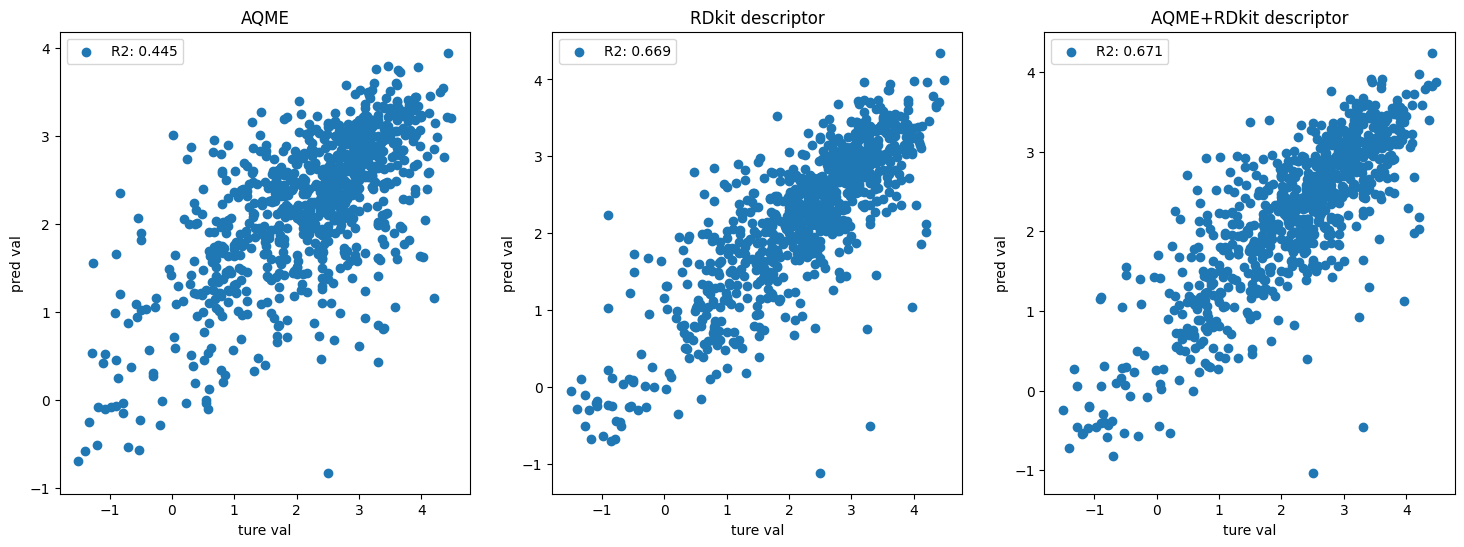

In [68]:
# プロット
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].scatter(y_test, y_pred_test_aqme, label=f'R2: {r2_aqme:.3f}')
ax[0].set_title('AQME')
ax[0].set_xlabel('ture val')
ax[0].set_ylabel('pred val')
ax[0].legend()
ax[1].scatter(y_test, y_pred_test_rddesc, label=f'R2: {r2_rddesc:.3f}')
ax[1].set_title('RDkit descriptor')
ax[1].set_xlabel('ture val')
ax[1].set_ylabel('pred val')
ax[1].legend()
ax[2].scatter(y_test, y_pred_test_mix, label=f'R2: {r2_mix:.3f}')
ax[2].set_title('AQME+RDkit descriptor')
ax[2].set_xlabel('ture val')
ax[2].set_ylabel('pred val')
ax[2].legend()
plt.show()

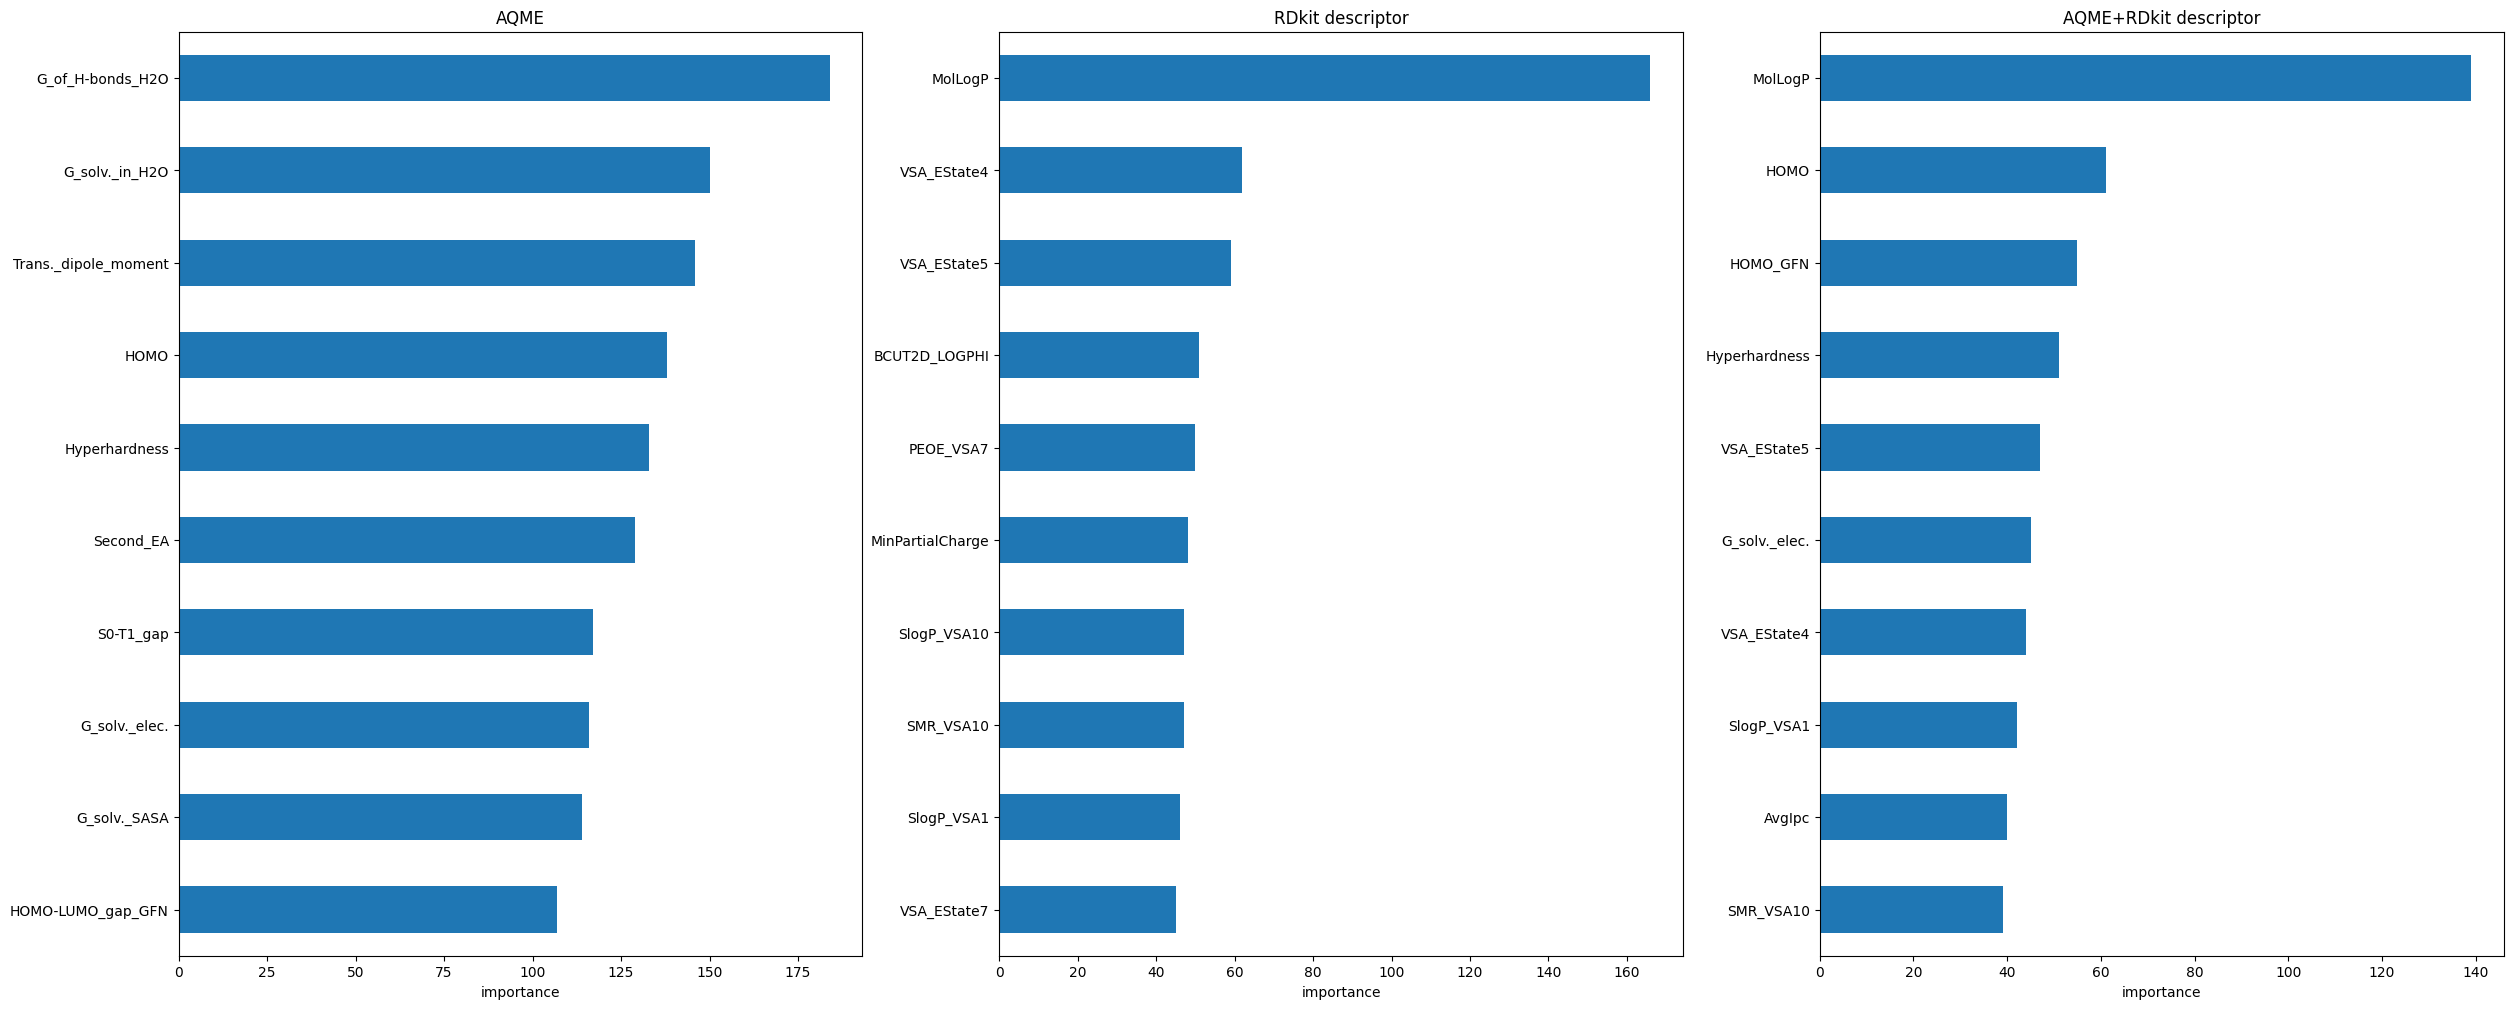

In [83]:
# 寄与度の可視化
cont_aqme = pd.Series(model_aqme.feature_importances_, index=model_aqme.feature_names_in_).sort_values(ascending=False).iloc[:10]
cont_rddesc = pd.Series(model_rddesc.feature_importances_, index=model_rddesc.feature_names_in_).sort_values(ascending=False).iloc[:10]
cont_mix = pd.Series(model_mix.feature_importances_, index=model_mix.feature_names_in_).sort_values(ascending=False).iloc[:10]
fig, ax = plt.subplots(1, 3, figsize=(30, 12))
cont_aqme[::-1].plot(ax=ax[0], kind='barh')
ax[0].set_title('AQME')
ax[0].set_xlabel('importance')
cont_rddesc[::-1].plot(ax=ax[1], kind='barh')
ax[1].set_title('RDkit descriptor')
ax[1].set_xlabel('importance')
cont_mix[::-1].plot(ax=ax[2], kind='barh')
ax[2].set_title('AQME+RDkit descriptor')
ax[2].set_xlabel('importance')
plt.show()

## EDA

In [6]:
# 欠損値の確認
df_desc.isna().sum()

code_name                          0
HOMO-LUMO gap                      1
HOMO                               1
LUMO                               1
IP                                 0
EA                                 0
Dipole module                      1
Total charge                       0
Global SASA                        0
G solv. in H2O                     0
G of H-bonds H2O                   0
Fermi-level                        0
Total polariz. alpha               0
Total FOD                          0
Hardness                           0
Softness                           0
Electronegativity                  0
Electrophil. idx                   0
Nucleophilicity idx                0
Second IP                          0
Second EA                         18
S0-T1 gap                          0
HOMO-LUMO gap_GFN                  0
HOMO_GFN                           0
LUMO_GFN                           0
Dipole module_GFN                  0
Total energy                       0
T

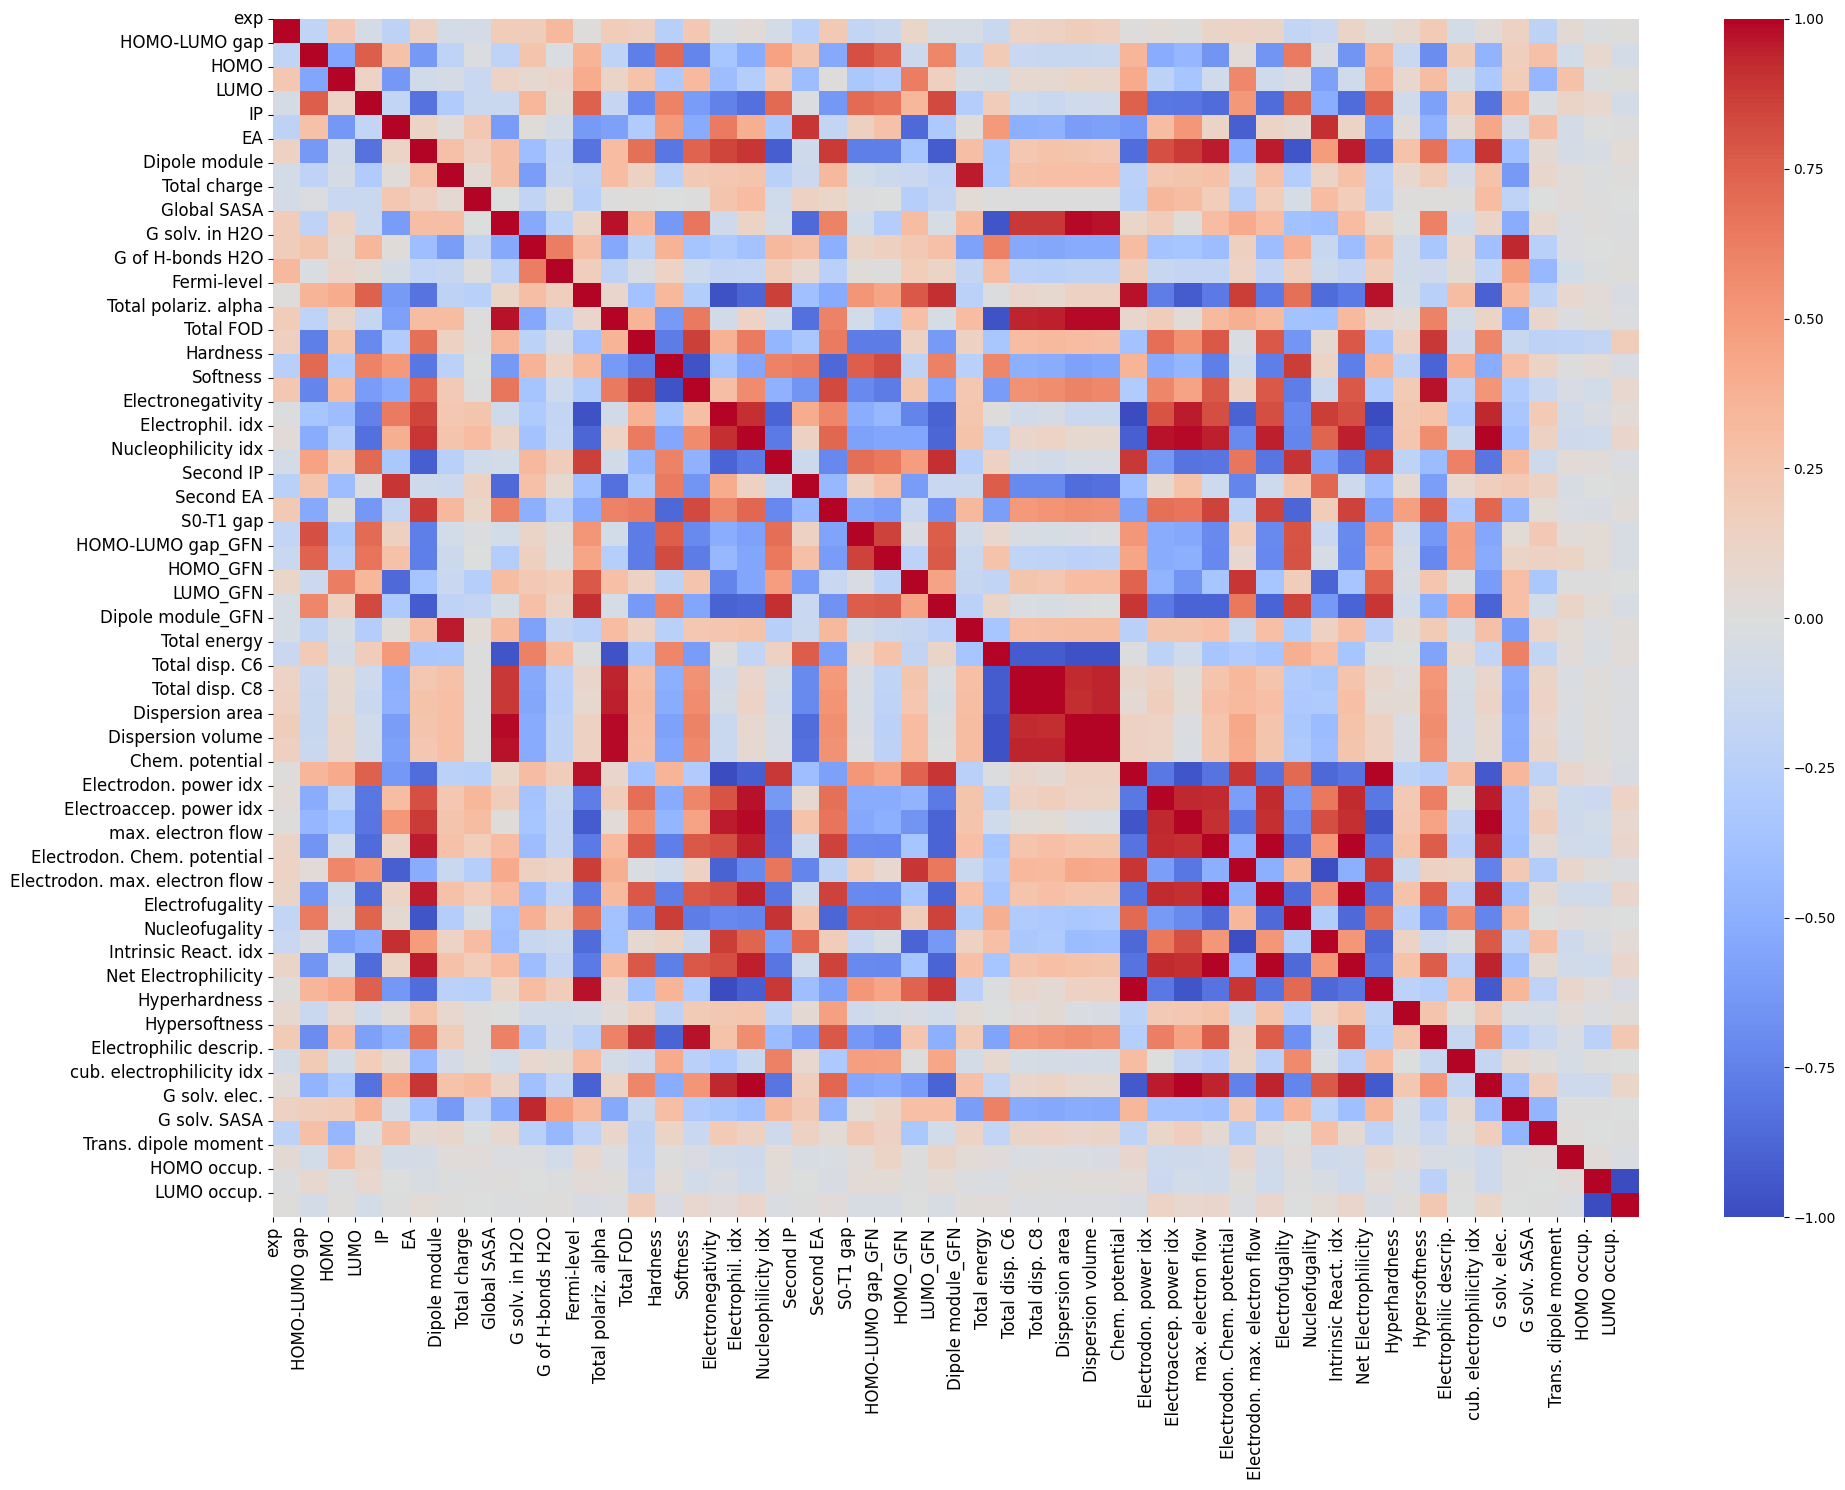

In [31]:
# 相関行列
corr_matrix = df_base.corr(numeric_only=True)
corr_matrix.drop(columns='G solv. shift', inplace=True)
corr_matrix.drop(index='G solv. shift', inplace=True)
fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, ax=ax)
ax.set_xticks(range(len(corr_matrix.columns)))
ax.set_xticklabels(corr_matrix.columns, rotation=90, fontsize=12)
ax.set_yticks(range(len(corr_matrix.index)))
ax.set_yticklabels(corr_matrix.index, rotation=0, fontsize=12)
plt.tight_layout()
plt.show()


In [24]:
corr_matrix

,exp,HOMO-LUMO gap,HOMO,LUMO,IP,EA,Dipole module,Total charge,Global SASA,G solv. in H2O,...,Hyperhardness,Hypersoftness,Electrophilic descrip.,cub. electrophilicity idx,G solv. elec.,G solv. SASA,G solv. shift,Trans. dipole moment,HOMO occup.,LUMO occup.
exp,1.000000,-0.201766,0.230085,-0.057762,-0.217925,0.135884,-0.072428,-0.064656,0.193755,0.172461,...,0.074336,0.201127,-0.077556,0.032670,0.143955,-0.211661,NaN,0.048441,-0.014684,0.014559
HOMO-LUMO gap,-0.201766,1.000000,-0.557678,0.750328,0.266929,-0.631706,-0.203238,-0.019139,-0.203918,0.244270,...,-0.135104,-0.692044,0.201011,-0.474755,0.170594,0.276522,NaN,-0.081486,0.074963,-0.073068
HOMO,0.230085,-0.557678,1.000000,0.130281,-0.634500,-0.089203,-0.058654,-0.143052,0.129609,0.064843,...,0.085783,0.299847,-0.073406,-0.319968,0.194463,-0.445456,NaN,0.265940,-0.012023,0.011704
LUMO,-0.057762,0.750328,0.130281,1.000000,-0.186485,-0.825595,-0.289473,-0.136789,-0.140352,0.343415,...,-0.092998,-0.587553,0.181267,-0.821906,0.358642,-0.024468,NaN,0.114464,0.079967,-0.077956
IP,-0.217925,0.266929,-0.634500,-0.186485,1.000000,0.122099,0.026495,0.227666,-0.616007,0.016137,...,0.028521,-0.486362,0.058109,0.435845,-0.067535,0.292441,NaN,-0.075691,-0.002303,0.002414
EA,0.135884,-0.631706,-0.089203,-0.825595,0.122099,1.000000,0.279889,0.160533,0.295416,-0.402434,...,0.263207,0.677037,-0.431053,0.895703,-0.386597,0.061507,NaN,-0.059995,-0.042334,0.040648
Dipole module,-0.072428,-0.203238,-0.058654,-0.289473,0.026495,0.279889,1.000000,0.055329,0.290145,-0.605140,...,0.078632,0.190218,-0.067739,0.263037,-0.622956,0.093689,NaN,0.027058,-0.015076,0.014128
Total charge,-0.064656,-0.019139,-0.143052,-0.136789,0.227666,0.160533,0.055329,1.000000,-0.005318,-0.192808,...,0.008517,0.008969,0.007617,0.298978,-0.206323,-0.005566,NaN,0.029214,0.000695,-0.000661
Global SASA,0.193755,-0.203918,0.129609,-0.140352,-0.616007,0.295416,0.290145,-0.005318,1.000000,-0.533478,...,-0.001630,0.610271,-0.078183,0.115305,-0.517183,0.073096,NaN,-0.021130,0.014457,-0.014423
G solv. in H2O,0.172461,0.244270,0.064843,0.343415,0.016137,-0.402434,-0.605140,-0.192808,-0.533478,1.000000,...,-0.089331,-0.329931,0.083537,-0.385997,0.933710,-0.248485,NaN,-0.016969,-0.002742,0.003490


In [19]:
df_desc[df_desc.isna().any(axis=1)]

,code_name,HOMO-LUMO gap,HOMO,LUMO,IP,EA,Dipole module,Total charge,Global SASA,G solv. in H2O,...,Hyperhardness,Hypersoftness,Electrophilic descrip.,cub. electrophilicity idx,G solv. elec.,G solv. SASA,G solv. shift,Trans. dipole moment,HOMO occup.,LUMO occup.
688,CHEMBL2036745,8.4367,-8.5081,-0.0715,7.2778,0.9277,3.2879,0.0,712.5045,-25.1979,...,NaN,NaN,1.4084,1.4913,-15.9842,-0.9907,0.6782,5.3768,2.0,0.0
725,CHEMBL423,10.6985,-9.0232,1.6753,7.0291,-1.8608,2.4614,0.0,619.4075,-8.0612,...,NaN,NaN,2.1554,0.6310,-4.8360,-0.3466,0.6782,3.9240,2.0,0.0
906,CHEMBL2010834,9.7447,-9.1504,0.5943,7.2208,0.4132,5.7307,0.0,724.2330,-19.9315,...,NaN,NaN,1.3794,1.2648,-18.7251,2.0276,0.6782,3.1053,2.0,0.0
1025,CHEMBL1164070,9.0613,-9.2168,-0.1555,7.7105,0.7224,4.5526,0.0,562.5991,-13.4457,...,NaN,NaN,1.3878,1.4549,-12.7826,1.1442,0.6782,0.4186,2.0,0.0
1224,CHEMBL1824041,NaN,NaN,NaN,6.9197,1.0084,NaN,0.0,721.7835,-19.5231,...,4.7760,0.0232,1.2117,1.4644,-13.1663,-2.3219,0.6782,2.5083,2.0,0.0
1472,CHEMBL1715893,13.2277,-9.6397,3.5880,7.9032,-8.1059,2.2649,0.0,360.2567,-7.6797,...,4.8947,0.0012,NaN,0.1009,-3.3618,-0.4426,0.6782,0.7820,2.0,0.0
1589,CHEMBL2164745,7.8563,-8.6468,-0.7905,6.6234,0.8448,6.6254,0.0,722.6985,-18.5821,...,NaN,NaN,1.1129,1.3392,-14.0676,-0.7555,0.6782,0.4432,2.0,0.0
1702,CHEMBL2086675,8.1527,-7.5774,0.5753,6.8992,0.0271,2.9493,0.0,638.5653,-15.6240,...,NaN,NaN,1.3510,1.0727,-10.4709,-3.5011,0.6782,1.7859,2.0,0.0
2064,CHEMBL218713,9.5031,-8.5449,0.9581,7.0355,-0.2243,2.8399,0.0,609.0336,-15.6203,...,NaN,NaN,1.4731,1.0203,-11.2183,-2.5321,0.6782,0.3630,2.0,0.0
2164,CHEMBL1916541,8.0668,-8.5653,-0.4985,6.5772,0.7437,8.6750,0.0,745.2113,-19.7348,...,NaN,NaN,1.1329,1.2900,-15.8307,-1.3383,0.6782,1.9144,2.0,0.0
